## Libraries

In [1]:
import numpy as np
import pandas as pd

# We import the sk learn modules we'll need to segment our new data. We'll need scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# We import pickle in order to be able to load our pickled objects.
import pickle
# We import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 
#We import the necessary libraries for visualization. We set seaborn do be our default.
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
# We import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

## Data Preparation

In [2]:
#load data
df_purchase = pd.read_csv('data/purchase data.csv')
# Import Scaler
scaler = pickle.load(open('scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open('pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()

# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

In [3]:
df_pa.columns

Index(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4',
       'Promotion_5', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size', 'Segment', 'Segment_0', 'Segment_1',
       'Segment_2', 'Segment_3'],
      dtype='object')

In [4]:
df_pa['Segment_1']

0        1
1        1
2        1
3        1
4        1
        ..
58688    1
58689    1
58690    1
58691    1
58692    1
Name: Segment_1, Length: 58693, dtype: uint8

## Purchase Probability Model

In [5]:
# In order to predict we need input and output variables. 
# Our Y is Incidence, as we want to predict the purchase probability for our customers
Y = df_pa['Incidence']

In [6]:
Y

0        0
1        0
2        0
3        0
4        0
        ..
58688    0
58689    0
58690    0
58691    1
58692    0
Name: Incidence, Length: 58693, dtype: int64

In [7]:
# Our dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [8]:
# We create a Logistic Regression model using sk learn. Then we fit the model with our X or price and our Y or incidence.
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
# The coefficients for price. It is negative, signaling that with an increase in price, the purchase probability decreases.
model_purchase.coef_

array([[-2.34736816]])

## Price Elasticity of Purchase Probability

In [10]:
# Here we see the prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [11]:
# We introduce the price range for which we'll examine the purchase probability.
# We choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8. 
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [12]:
df_price_range = pd.DataFrame(price_range)

In [13]:
# We predict the purchase probability for our newly defined price range. 
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
# purchase_pr = Y_pr[:, 1]

pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [14]:
#Test
#Y_pr
#Y_pr[1]
#print(Y_pr[:, 1])
model_purchase.coef_[:, 0]

array([-2.34736816])

In [15]:
# Create price elasticities master data frame.
# It will contain all the elasticities we calculate during the purchase analytics part of the course.
df_price_elasticities = pd.DataFrame(price_range)

In [16]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096279
1,0.51,-0.100342
2,0.52,-0.104531
3,0.53,-0.108850
4,0.54,-0.113303
...,...,...
295,3.45,-8.010291
296,3.46,-8.035538
297,3.47,-8.060750
298,3.48,-8.085929


In [17]:
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096279
1,0.51,-0.100342
2,0.52,-0.104531
3,0.53,-0.108850
4,0.54,-0.113303
5,0.55,-0.117892
6,0.56,-0.122620
7,0.57,-0.127492
8,0.58,-0.132510
9,0.59,-0.137678


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

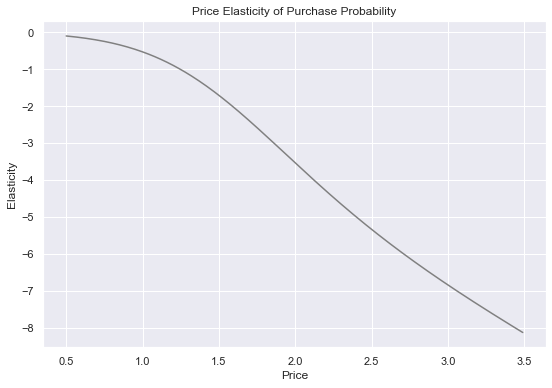

In [18]:
# We display the price elasticity of purchase probability of the average customer.
# We observe that the price elasticities are all negative. Furthermore we can spot where the customer becomes inelastic.
# But to find the precise spot we can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability by Segments

### $\color{green}{\text{Segment 3 - Career-Focused}}$

In [19]:
# We filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]

In [20]:
# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_3['Incidence']

In [21]:
X = pd.DataFrame()

In [22]:
# We calculate the average price for purchases in segment 1. Our dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

In [23]:
# Fit logistic regression model
model_incidence_segment_3 = LogisticRegression(solver = 'sag')
model_incidence_segment_3.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
# We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segment_3.coef_

array([[-1.71165078]])

In [25]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_3 = model_incidence_segment_3.predict_proba(df_price_range)
purchase_pr_segment_3 = Y_segment_3[:][:, 1]
pe_segment3 = model_incidence_segment_3.coef_[:, 0] * price_range * (1 - purchase_pr_segment_3)

### Results

In [27]:
df_price_elasticities['PE_Segment_3'] = pe_segment3

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

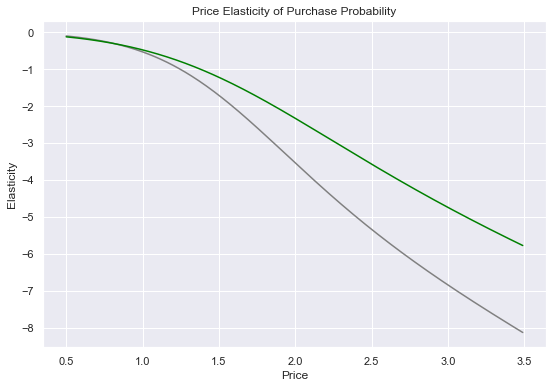

In [28]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in green. The same color we used during the descriptive analysis.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment3, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{red}{\text{Segment 1 - Fewer-Opportunities}}$

In [29]:
# Select only customers from segment 1, the fewer-opportunities.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [30]:
# Logistic regression model
Y = df_pa_segment_1['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

model_incidence_segment1 = LogisticRegression(solver = 'sag')
model_incidence_segment1.fit(X, Y)

# Calculate price elasticities
model_incidence_segment1.coef_
Y_segment_1 = model_incidence_segment1.predict_proba(df_price_range)
purchase_pr_segment1 = Y_segment_1[:][: , 1]
pe_segment1 = model_incidence_segment1.coef_[:,0] * price_range * ( 1- purchase_pr_segment1)

### Results

In [31]:
df_price_elasticities['PE_Segment_1'] = pe_segment1

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

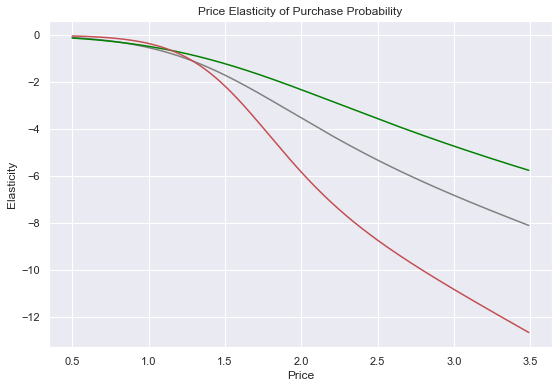

In [32]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment3, color = 'green')
plt.plot(price_range, pe_segment1, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## ${\textbf{Homework}}$

### $\color{blue}{\text{Segment 2 - Standard}}$

In [33]:
# Select only customers from segment 2, the standard segment.
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]
# Prepare dependant and independant variables.
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5
# Logistic regression model
model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range *( 1- purchase_pr_segment2)
df_price_elasticities.insert(2, column = 'PE_Segment_2', value = pe_segment2)

### $\color{orange}{\text{Segment 0 - Well-Off}}$

In [34]:
# Select only customers from segment 3 
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities['PE_Segment_0'] = pe_segment0
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533
5,0.55,-0.117892,-0.243936,-0.141046,-0.040746,-0.193755
6,0.56,-0.122620,-0.251065,-0.145712,-0.042990,-0.199049
7,0.57,-0.127492,-0.258308,-0.150480,-0.045343,-0.204416
8,0.58,-0.132510,-0.265665,-0.155350,-0.047808,-0.209856
9,0.59,-0.137678,-0.273137,-0.160323,-0.050391,-0.215370


### ${\textbf{Results}}$

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

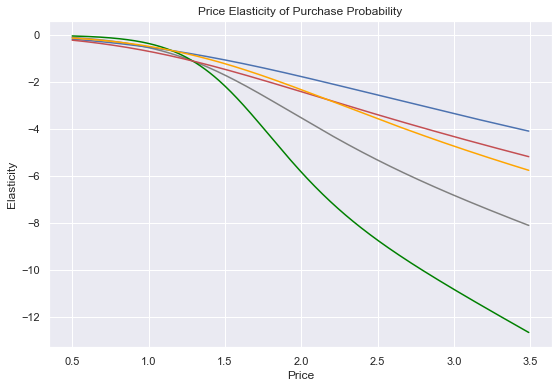

In [35]:
# We display all elasticities of purchase probability on the same plot. 
# We observe that the Career-focused segment are the least elastic when compared to the rest. 
# So, their purchase probability elasticity is not as affected by price.
# The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that
# the standard segment is least homogenous, which we discovered during our descriptive analysis. 
# It may be that the customers in this segment have different shopping habbits, which is why their 
# customers start with being more elastic than average but then shift to being more inelastic than the average customer
# and indeed the Career-focused segment.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability with Promotion Feature

### Data Preparation

In [36]:
Y = df_pa['Incidence']

In [37]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [38]:
# We include a second promotion feature. We'd like to examine the effects of promotions on purchase probability.
# We calculate the average promotion rate across the five brands. We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [39]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49405978,  0.56157891]])

## Price Elasticity with Promotion

In [40]:
# We create a data frame on which our model will predict. We need to include A price and promotion feature.
# First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [41]:
df_price_elasticity_promotion

,Price_Range
0,0.50
1,0.51
2,0.52
3,0.53
4,0.54
5,0.55
6,0.56
7,0.57
8,0.58
9,0.59


In [42]:
# We'll calculate price elasticities of purchase probability when we assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [43]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [44]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [45]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0,Elasticity_Promotion_1
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363,-0.125730
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299,-0.129846
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306,-0.134042
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384,-0.138317
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533,-0.142672
5,0.55,-0.117892,-0.243936,-0.141046,-0.040746,-0.193755,-0.147110
6,0.56,-0.122620,-0.251065,-0.145712,-0.042990,-0.199049,-0.151631
7,0.57,-0.127492,-0.258308,-0.150480,-0.045343,-0.204416,-0.156236
8,0.58,-0.132510,-0.265665,-0.155350,-0.047808,-0.209856,-0.160925
9,0.59,-0.137678,-0.273137,-0.160323,-0.050391,-0.215370,-0.165701


## Price Elasticity without Promotion

In [46]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [47]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [48]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [49]:
no_promo = Y_no_promo[: , 1]

In [50]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [51]:
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability with and without Promotion')

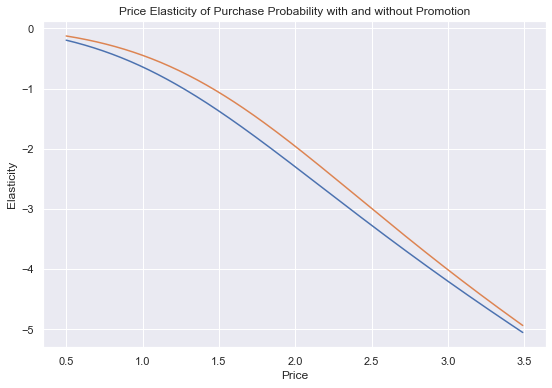

In [52]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
# Here we observe that the purchase probability elasticity of the customer is less elastic when there is promotion.
# This is an important insight for marketers, as according to our model people are more likely to buy a product if there is
# some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo)
plt.plot(price_range, price_elasticity_promo)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')

## ${\textbf{Brand Choice}}$

### Data Preparation

In [54]:
# Here we are interested in determining the brand choice of the customer. 
# Hence, we filter our data, to include only purchase occasion, when a purchase has occured. 
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [55]:
# We cap the maximum displayed rows in a table, to make computation more efficient and easier readability.
pd.options.display.max_rows = 100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,1,0,1,0,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,1,0,1,0,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,1,0,1,0,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,1,0,1,0,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,42,1,120946,1,0,1,0,1,0,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,42,1,120946,1,0,1,0,1,0,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,42,1,120946,1,0,1,0,1,0,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,42,1,120946,1,0,1,0,1,0,0


In [56]:
# Our model will predict the brand.
Y = brand_choice['Brand']

In [57]:
# Here we decide which features to include for prediction.
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [58]:
# We predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [59]:
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
# Here are the coeffictients for the model. We have five brands and five features for the price. 
# Therefore, this output is somewhat difficult to read.
model_brand_choice.coef_

array([[-3.91597728,  0.65845181,  2.41763074,  0.70407042, -0.20213473],
       [ 1.27460884, -1.87985687, -0.21265451, -0.20634405,  0.58786907],
       [ 1.62421912,  0.5621222 ,  0.50100208,  1.03953162,  0.4528185 ],
       [ 0.57453308,  0.39558617, -1.40061786, -1.24624695,  0.24934795],
       [ 0.44261623,  0.26369668, -1.30536044, -0.29101104, -1.08790078]])

In [61]:
# We create a pandas data frame, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915977,0.658452,2.417631,0.704070,-0.202135
1,1.274609,-1.879857,-0.212655,-0.206344,0.587869
2,1.624219,0.562122,0.501002,1.039532,0.452818
3,0.574533,0.395586,-1.400618,-1.246247,0.249348
4,0.442616,0.263697,-1.305360,-0.291011,-1.087901


In [62]:
# We make some transformations on the coefficients data frame to increase readability.
# We transpose the data frame, to keep with the conventional representation of results.
# We add labels for the columns and the index, which represent the coefficients of the brands and prices, respectively. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [63]:
# We want to calculate price elasticity of brand choice.
# Here we create a data frame with price columns, which our model will use to predict the brand choice probabilities.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [73]:
# Brand Choice Model prediction.
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)
predict_brand_5

array([[0.03290878, 0.02177645, 0.00543757, 0.02988815, 0.90998906],
       [0.03316351, 0.02211907, 0.00551566, 0.03025579, 0.90894597],
       [0.03341974, 0.02246675, 0.0055948 , 0.03062752, 0.90789119],
       ...,
       [0.06881323, 0.47570458, 0.07953517, 0.23889453, 0.13705249],
       [0.06852761, 0.47748738, 0.07972551, 0.23897947, 0.13528004],
       [0.06824104, 0.47926188, 0.07991379, 0.23905696, 0.13352633]])

In [72]:
# Our model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the fifth brand we need to obtain the last column located on position 4,
# as we're starting to count from 0.
pr_own_brand_5 = predict_brand_5[: ][:, 4]
pr_own_brand_5

array([0.90998906, 0.90894597, 0.90789119, 0.9068246 , 0.90574608,
       0.90465554, 0.90355286, 0.90243792, 0.90131061, 0.90017083,
       0.89901846, 0.89785337, 0.89667548, 0.89548465, 0.89428077,
       0.89306374, 0.89183343, 0.89058973, 0.88933254, 0.88806173,
       0.88677718, 0.8854788 , 0.88416646, 0.88284004, 0.88149944,
       0.88014455, 0.87877523, 0.8773914 , 0.87599292, 0.87457969,
       0.8731516 , 0.87170853, 0.87025038, 0.86877702, 0.86728836,
       0.86578427, 0.86426466, 0.86272941, 0.86117841, 0.85961156,
       0.85802875, 0.85642988, 0.85481483, 0.85318351, 0.85153581,
       0.84987163, 0.84819086, 0.84649342, 0.8447792 , 0.8430481 ,
       0.84130003, 0.83953489, 0.83775258, 0.83595303, 0.83413613,
       0.8323018 , 0.83044995, 0.82858049, 0.82669335, 0.82478843,
       0.82286567, 0.82092498, 0.81896628, 0.81698951, 0.81499458,
       0.81298144, 0.81095001, 0.80890024, 0.80683205, 0.80474538,
       0.80264019, 0.80051642, 0.798374  , 0.79621291, 0.79403

In [66]:
# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [67]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [68]:
# Adding the price elasticities to our master data frame. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363,-0.125730,-0.195650,-0.049056
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299,-0.129846,-0.201772,-0.050617
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306,-0.134042,-0.207996,-0.052207
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384,-0.138317,-0.214323,-0.053827
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533,-0.142672,-0.220755,-0.055478
5,0.55,-0.117892,-0.243936,-0.141046,-0.040746,-0.193755,-0.147110,-0.227291,-0.057159
6,0.56,-0.122620,-0.251065,-0.145712,-0.042990,-0.199049,-0.151631,-0.233933,-0.058871
7,0.57,-0.127492,-0.258308,-0.150480,-0.045343,-0.204416,-0.156236,-0.240682,-0.060615
8,0.58,-0.132510,-0.265665,-0.155350,-0.047808,-0.209856,-0.160925,-0.247538,-0.062391
9,0.59,-0.137678,-0.273137,-0.160323,-0.050391,-0.215370,-0.165701,-0.254502,-0.064200


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

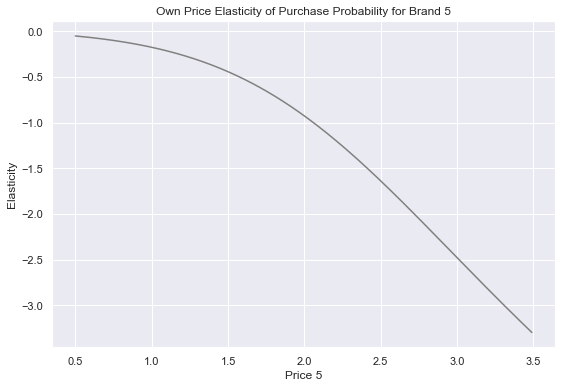

In [69]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')

## Cross Price Elasticity Brand 5, Cross Brand 4

In [82]:
# We want to examine the effect of the changes in price of a competitor brand.
# As we've discussed in the lecture, the brand which comes closest to our own brand is brand 4. 
# Therefore, we need to examine changes in the price of this brand.
# Keep in mind, we could examine the cross price elasticities for any of the remaining brands, 
# we just need to update this data frame accordingly to contain the respective brand.
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [84]:
price_range.size

300

In [75]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [76]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [77]:
# As now we're interested in what the probability of choosing the competitor brand is, 
# we need to select the purchase probability for brand 4, contained in the 4th column with index 3. 
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [78]:
beta5

-1.09

In [79]:
# In order to calculate the cross brand price elasticity, we need to use the new formula we introduced in the lecture.
# The elasticity is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

In [80]:
# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363,-0.125730,-0.195650,-0.049056,0.332011
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299,-0.129846,-0.201772,-0.050617,0.337287
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306,-0.134042,-0.207996,-0.052207,0.342507
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384,-0.138317,-0.214323,-0.053827,0.347668
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533,-0.142672,-0.220755,-0.055478,0.352773
5,0.55,-0.117892,-0.243936,-0.141046,-0.040746,-0.193755,-0.147110,-0.227291,-0.057159,0.357820
6,0.56,-0.122620,-0.251065,-0.145712,-0.042990,-0.199049,-0.151631,-0.233933,-0.058871,0.362809
7,0.57,-0.127492,-0.258308,-0.150480,-0.045343,-0.204416,-0.156236,-0.240682,-0.060615,0.367741
8,0.58,-0.132510,-0.265665,-0.155350,-0.047808,-0.209856,-0.160925,-0.247538,-0.062391,0.372614
9,0.59,-0.137678,-0.273137,-0.160323,-0.050391,-0.215370,-0.165701,-0.254502,-0.064200,0.377430


Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

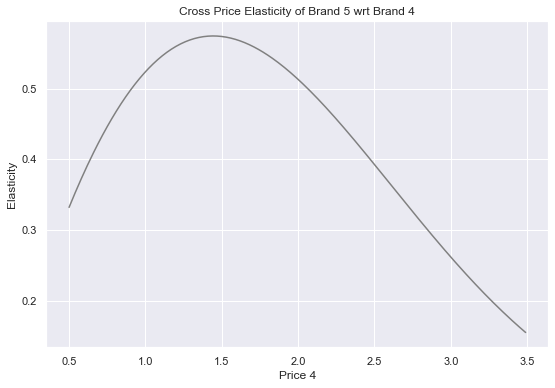

In [81]:
# Here we examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4.
# We observe they are positive. As the price of the competitor brand increases, 
# so does the probability for purchasing our own brand.
# Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, 
# signalling that the increase in purchase probability for the own brand happens more slowly.
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

## Own and Cross-Price Elasticity by Segment

### $\color{orange}{\text{Well-Off}}$

In [85]:
# We are interested in analysing the purchase probability for choosing brand 5 by segments.
# We filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]

pd.options.display.max_rows = 100
brand_choice_s0

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,52,2,159052,2,1,0,1,0,0,0
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,52,2,159052,2,1,0,1,0,0,0
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,52,2,159052,2,1,0,1,0,0,0
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,52,2,159052,2,1,0,1,0,0,0
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,52,2,159052,2,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,...,44,2,193816,2,1,0,1,0,0,0
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,...,44,2,193816,2,1,0,1,0,0,0
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,...,44,2,193816,2,1,0,1,0,0,0
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,...,44,2,193816,2,1,0,1,0,0,0


In [86]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s0.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [87]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities['Brand 5 S0'] = own_price_elasticity_brand_5_s0

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [88]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities['Brand_5_Cross_Brand_4_S0'] = brand5_cross_brand4_price_elasticity_s0
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363,-0.125730,-0.195650,-0.049056,0.332011,-0.297325,0.482421
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299,-0.129846,-0.201772,-0.050617,0.337287,-0.303371,0.491726
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306,-0.134042,-0.207996,-0.052207,0.342507,-0.309428,0.501016
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384,-0.138317,-0.214323,-0.053827,0.347668,-0.315495,0.510290
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533,-0.142672,-0.220755,-0.055478,0.352773,-0.321573,0.519548
5,0.55,-0.117892,-0.243936,-0.141046,-0.040746,-0.193755,-0.147110,-0.227291,-0.057159,0.357820,-0.327663,0.528790
6,0.56,-0.122620,-0.251065,-0.145712,-0.042990,-0.199049,-0.151631,-0.233933,-0.058871,0.362809,-0.333764,0.538017
7,0.57,-0.127492,-0.258308,-0.150480,-0.045343,-0.204416,-0.156236,-0.240682,-0.060615,0.367741,-0.339878,0.547227
8,0.58,-0.132510,-0.265665,-0.155350,-0.047808,-0.209856,-0.160925,-0.247538,-0.062391,0.372614,-0.346004,0.556420
9,0.59,-0.137678,-0.273137,-0.160323,-0.050391,-0.215370,-0.165701,-0.254502,-0.064200,0.377430,-0.352144,0.565598


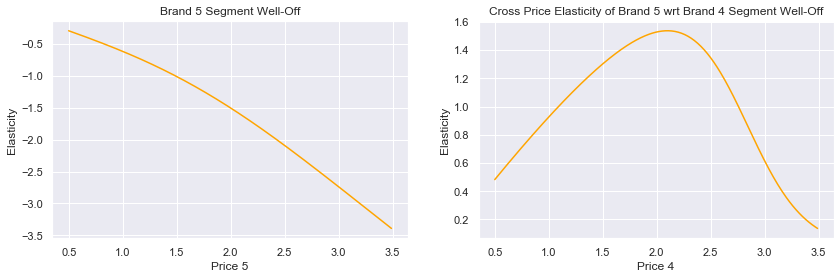

In [89]:
# Using a figure with axes we plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s0, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

### $\color{blue}{\text{Standard}}$

In [91]:
# Here we are interesting in analysing the brand choice probability of the Standard segment.
# We filter our data, by selecting only purchases from segment 2.
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]
brand_choice_s2.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,32,1,88428,0,0,2,0,0,1,0
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,...,32,1,88428,0,0,2,0,0,1,0
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,...,32,1,88428,0,0,2,0,0,1,0
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,...,32,1,88428,0,0,2,0,0,1,0
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,...,32,1,88428,0,0,2,0,0,1,0


In [92]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [94]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

# Compute price elasticities and update master data frame.
# We'd like to include the elasticities for the segments in order from 0 to three, which is why we use insert() on position 10.
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(10, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [95]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Standard segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

# Compute price elasticities and update master data frame.
# We need to use insert() on position 11, to save the price elasticities in the correct order.
brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)

### $\color{green}{\text{Career-Focused}}$

In [97]:
# Filter data by the Career-focused segment, which is the first segment.
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

In [98]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [99]:
# Calculating own-brand price elasticity for brand 5 and the Career-focused segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities.insert(12, column = 'Brand 5 S3', value = own_price_elasticity_brand_5_s3)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [101]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S3', value = brand5_cross_brand4_price_elasticity_s3)

### $\color{red}{\text{Fewer-Opportunities}}$

In [103]:
# Filter data, select only purchases from segment 1, which is the Fewer-Opportunities segment.
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [104]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [105]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-opportunities segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(14, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [107]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer-opportunities segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S0,Brand_5_Cross_Brand_4_S0
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363,-0.125730,-0.195650,-0.049056,0.332011,-0.116301,0.160493,-0.043941,0.194768,-0.001034,0.187010,-0.297325,0.482421
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299,-0.129846,-0.201772,-0.050617,0.337287,-0.119350,0.162443,-0.045027,0.197252,-0.001096,0.189373,-0.303371,0.491726
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306,-0.134042,-0.207996,-0.052207,0.342507,-0.122433,0.164348,-0.046123,0.199685,-0.001160,0.191685,-0.309428,0.501016
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384,-0.138317,-0.214323,-0.053827,0.347668,-0.125552,0.166208,-0.047229,0.202067,-0.001228,0.193946,-0.315495,0.510290
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533,-0.142672,-0.220755,-0.055478,0.352773,-0.128707,0.168024,-0.048344,0.204399,-0.001300,0.196158,-0.321573,0.519548
5,0.55,-0.117892,-0.243936,-0.141046,-0.040746,-0.193755,-0.147110,-0.227291,-0.057159,0.357820,-0.131897,0.169795,-0.049468,0.206681,-0.001375,0.198319,-0.327663,0.528790
6,0.56,-0.122620,-0.251065,-0.145712,-0.042990,-0.199049,-0.151631,-0.233933,-0.058871,0.362809,-0.135125,0.171522,-0.050602,0.208914,-0.001455,0.200430,-0.333764,0.538017
7,0.57,-0.127492,-0.258308,-0.150480,-0.045343,-0.204416,-0.156236,-0.240682,-0.060615,0.367741,-0.138389,0.173205,-0.051746,0.211097,-0.001538,0.202492,-0.339878,0.547227
8,0.58,-0.132510,-0.265665,-0.155350,-0.047808,-0.209856,-0.160925,-0.247538,-0.062391,0.372614,-0.141691,0.174846,-0.052899,0.213231,-0.001626,0.204505,-0.346004,0.556420
9,0.59,-0.137678,-0.273137,-0.160323,-0.050391,-0.215370,-0.165701,-0.254502,-0.064200,0.377430,-0.145031,0.176443,-0.054062,0.215317,-0.001718,0.206468,-0.352144,0.565598


Text(0.5, 0, 'Price 4')

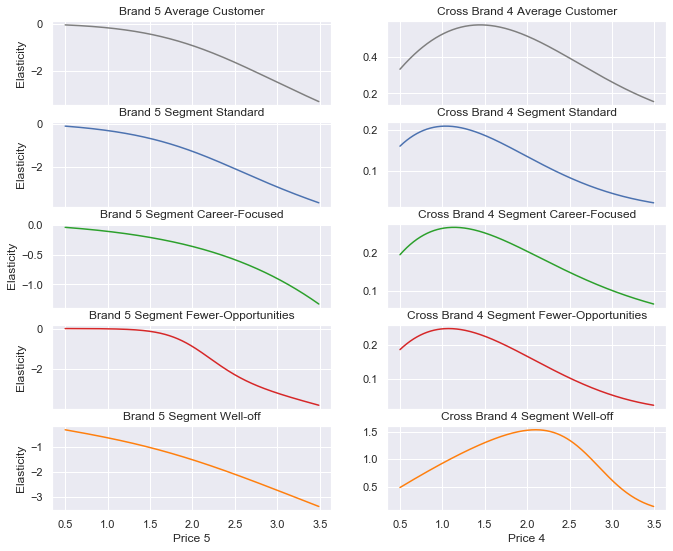

In [109]:
# We plot the own and cross brand price elasticities for the average customer and each of the four segments.
# We can observe differences and similiraties between the segments and examine their preference, when it comes to brand choice.
# The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
# and the Well-off. They are also the segments which purchase this brand most often. 
# The Career-focused segment is the most inelastic and they are the most loyal segment. 
# Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, 
# without fear of significant loss of customers from this segment. 
# The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often.
# In order to target this segment, our analysis signals, that price needs to be decreased. However, keep in mind 
# that other factors aside from price might be influencing the purchase behaivour of this segment.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s2)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s0, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')

## Price Elasticity of Purchase Quantity

In [128]:
# We want to determine price elasticity of purchase quantity, also known as price elasticity of demand.
# We are interested in purchase ocassion, where the purchased quantity is different from 0.
# Therefore, once again we filter our data to contain only shopping visits where the client has purchased at least one product.
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]
df_purchase_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,1,0,1,0,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,1,0,1,0,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,1,0,1,0,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,1,0,1,0,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,1,0,1,0,0


In [129]:
# Create brand dummies, for each of the five brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')
# The descriptive analysis of the purchase quantitiy data frame, shows that quantity ranges from 1 to 15 
# and has an average value of 2.8, which means that more often than not our customers buy more than 1 chocolate candy bar.
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,1.543244,0.231657,0.292731,0.176322,0.299290,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,1.144602,0.421906,0.455032,0.381107,0.457962,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [130]:
df_purchase_quantity

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
6,200000001,28,1,2,0,0,1.50,1.90,1.99,2.09,...,1,0,1,0,0,0,1,0,0,0
11,200000001,58,1,1,0,0,1.39,1.90,1.91,2.12,...,1,0,1,0,0,0,0,0,0,1
19,200000001,110,1,2,0,0,1.47,1.90,1.99,1.97,...,1,0,1,0,0,1,0,0,0,0
24,200000001,142,1,1,0,0,1.21,1.35,1.99,2.16,...,1,0,1,0,0,0,0,0,1,0
29,200000001,183,1,3,0,0,1.46,1.88,1.97,1.89,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,6,0,0,1.48,1.89,2.01,2.18,...,1,0,1,0,0,0,1,0,0,0
58648,200000500,460,1,12,0,0,1.35,1.57,2.02,2.21,...,1,0,1,0,0,1,0,0,0,0
58674,200000500,641,1,7,0,0,1.50,1.85,2.06,2.24,...,1,0,1,0,0,0,1,0,0,0
58687,200000500,697,1,6,0,0,1.42,1.51,1.97,2.24,...,1,0,1,0,0,0,1,0,0,0


In [112]:
# Here we make a decission on which features to include in our model. We decide to include a Price and a Promotion feature.
df_purchase_quantity.columns.values

array(['ID', 'Day', 'Incidence', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3', 'Brand_1',
       'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5'], dtype=object)

In [113]:
#Find the price of the product that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

In [114]:
#Find the price of the product that is chosen at this incidence
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

## Model Estimation. Linear Regression

In [115]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
pd.options.display.max_rows = 100
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [116]:
Y = df_purchase_quantity['Quantity']
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [117]:
# Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [118]:
# Linear Regression Model. The coefficients for price and promotion are both negative. 
# It appears that promotion reflects negatively on the purchase quantity of the average client, which is unexpected.
model_quantity.coef_

array([-0.8173651 , -0.10504673])

## Price Elasticity with Promotion

In [119]:
# We examine the price elasticity of purchase quantity with active promotional activities for each price point.
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

In [120]:
#Take the coefficient for price.
beta_quantity = model_quantity.coef_[0]
beta_quantity

-0.8173651016684998

In [121]:
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [122]:
# We calculate the price elasticity with our new formula. It is the beta coefficient for price multiplied by price
# and divided by the purchase quantity.
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

In [123]:
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S0,Brand_5_Cross_Brand_4_S0,PE_Quantity_Promotion_1
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363,-0.125730,-0.195650,-0.049056,0.332011,-0.116301,0.160493,-0.043941,0.194768,-0.001034,0.187010,-0.297325,0.482421,-0.102157
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299,-0.129846,-0.201772,-0.050617,0.337287,-0.119350,0.162443,-0.045027,0.197252,-0.001096,0.189373,-0.303371,0.491726,-0.104413
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306,-0.134042,-0.207996,-0.052207,0.342507,-0.122433,0.164348,-0.046123,0.199685,-0.001160,0.191685,-0.309428,0.501016,-0.106679
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384,-0.138317,-0.214323,-0.053827,0.347668,-0.125552,0.166208,-0.047229,0.202067,-0.001228,0.193946,-0.315495,0.510290,-0.108954
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533,-0.142672,-0.220755,-0.055478,0.352773,-0.128707,0.168024,-0.048344,0.204399,-0.001300,0.196158,-0.321573,0.519548,-0.111238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.010291,-5.110639,-5.680014,-12.529501,-4.029621,-4.861747,-4.983367,-3.231571,0.162235,-3.592240,0.024303,-1.287423,0.068594,-3.746031,0.022975,-3.337315,0.157491,-1.774292
296,3.46,-8.035538,-5.127660,-5.700167,-12.566386,-4.044503,-4.879949,-5.000273,-3.247765,0.160335,-3.606121,0.023942,-1.297232,0.067971,-3.757475,0.022522,-3.350646,0.152069,-1.788634
297,3.47,-8.060750,-5.144663,-5.720283,-12.603253,-4.059368,-4.898121,-5.017160,-3.263926,0.158449,-3.619959,0.023585,-1.307097,0.067353,-3.768899,0.022077,-3.363973,0.146812,-1.803124
298,3.48,-8.085929,-5.161646,-5.740362,-12.640104,-4.074217,-4.916262,-5.034026,-3.280056,0.156577,-3.633753,0.023233,-1.317016,0.066738,-3.780303,0.021638,-3.377297,0.141717,-1.817766


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

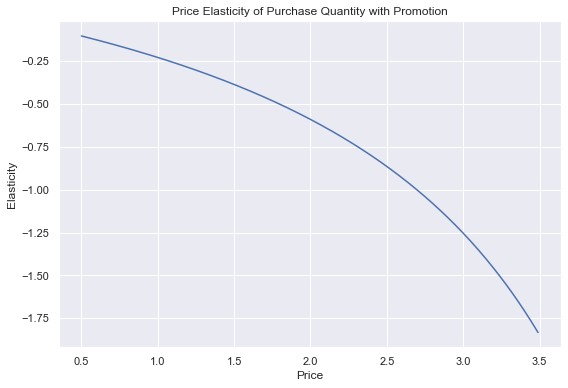

In [124]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

### Homework

## Price Elasticity without Promotion

In [125]:
# Overwrite promotion incidence in order to use the same df. 
# Here we assume there are no promotinal activities active for the entire price range.
df_price_elasticity_quantity['Promotion_Incidence'] = 0
# Find the new predicted quantities.
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)
# Calculate the new price elasticities.
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity
# Add the results to the master data frame.
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_2,PE_Segment_3,PE_Segment_1,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S0,Brand_5_Cross_Brand_4_S0,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096279,-0.209966,-0.119170,-0.030988,-0.168363,-0.125730,-0.195650,-0.049056,0.332011,-0.116301,0.160493,-0.043941,0.194768,-0.001034,0.187010,-0.297325,0.482421,-0.102157,-0.099543
1,0.51,-0.100342,-0.216539,-0.123356,-0.032758,-0.173299,-0.129846,-0.201772,-0.050617,0.337287,-0.119350,0.162443,-0.045027,0.197252,-0.001096,0.189373,-0.303371,0.491726,-0.104413,-0.101736
2,0.52,-0.104531,-0.223222,-0.127635,-0.034615,-0.178306,-0.134042,-0.207996,-0.052207,0.342507,-0.122433,0.164348,-0.046123,0.199685,-0.001160,0.191685,-0.309428,0.501016,-0.106679,-0.103939
3,0.53,-0.108850,-0.230015,-0.132008,-0.036562,-0.183384,-0.138317,-0.214323,-0.053827,0.347668,-0.125552,0.166208,-0.047229,0.202067,-0.001228,0.193946,-0.315495,0.510290,-0.108954,-0.106150
4,0.54,-0.113303,-0.236920,-0.136478,-0.038604,-0.188533,-0.142672,-0.220755,-0.055478,0.352773,-0.128707,0.168024,-0.048344,0.204399,-0.001300,0.196158,-0.321573,0.519548,-0.111238,-0.108369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.010291,-5.110639,-5.680014,-12.529501,-4.029621,-4.861747,-4.983367,-3.231571,0.162235,-3.592240,0.024303,-1.287423,0.068594,-3.746031,0.022975,-3.337315,0.157491,-1.774292,-1.664290
296,3.46,-8.035538,-5.127660,-5.700167,-12.566386,-4.044503,-4.879949,-5.000273,-3.247765,0.160335,-3.606121,0.023942,-1.297232,0.067971,-3.757475,0.022522,-3.350646,0.152069,-1.788634,-1.677205
297,3.47,-8.060750,-5.144663,-5.720283,-12.603253,-4.059368,-4.898121,-5.017160,-3.263926,0.158449,-3.619959,0.023585,-1.307097,0.067353,-3.768899,0.022077,-3.363973,0.146812,-1.803124,-1.690246
298,3.48,-8.085929,-5.161646,-5.740362,-12.640104,-4.074217,-4.916262,-5.034026,-3.280056,0.156577,-3.633753,0.023233,-1.317016,0.066738,-3.780303,0.021638,-3.377297,0.141717,-1.817766,-1.703414


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

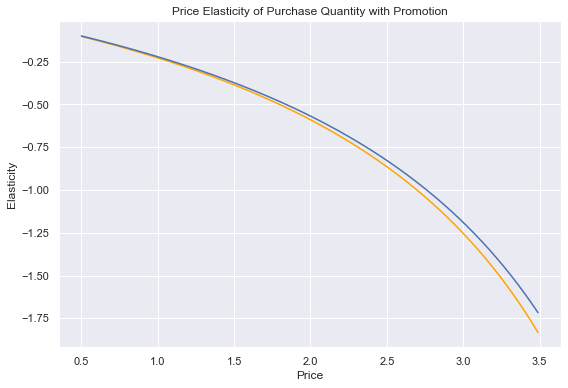

In [126]:
# Plot the two elasticities side by side. 
# We observe that the two elasticities are very close together for almost the entire price range.
# It appears that promotion does not appear to be a significant factor in the customers' decission 
# what quantity of chocolate candy bars to purchase.
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'orange')
plt.plot(price_range, price_elasticity_quantity_promotion_no)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')